In [1]:
import numpy as np
import glob
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#import stagnation.variables as va
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

In [2]:
def gaussian(x, sig): #fonction de Gauss utlisé pour la normalisation et le calcul des poids de chaque points
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*(x/sig)**2)

In [3]:
L = 120 #box size
dx = 120/2**9 #minimum grid size
print(dx)
R0 = 8 #bubble equivalent radius
folderfig='/home/turbots/Documents/figure/'
eps = 7.8 #mean dissipation without the bubble
rho  = 1 #fluid density (taken as reference)
sig=dx/2

0.234375


In [4]:
pref = 2*rho*eps**(2/3)*(2*R0)**(5/3)
print(pref,pref/8)

799.1464389491427 99.89330486864284


In [322]:
def expo_decr(x,a,b,cte):
    return np.exp((-1/a)*x+b)+cte

In [63]:
folds = glob.glob('Re*') # we pick up all the files that start with Re and put them in folds
len(folds)# lenght of folds

422

In [277]:
folds0 = 'Re55t140-l9-8-3000-2-dump_1-dump_1'
filesdissint = glob.glob(folds0+ '/localstats_[!f]*')
filesdissext = glob.glob(folds0 + '/localstats_fluid*')
filesinterf = glob.glob(folds0 + '/inter*.dat')
        
    

import warnings

with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
    warnings.simplefilter("ignore") 
    dataint = np.zeros([0, 7], dtype=float)
    dataext = np.zeros([0, 6], dtype=float)
    interf = np.zeros([0, 10], dtype=float)
    bubble = np.zeros([0, 12], dtype=float)
    stat = np.zeros([0, 8], dtype=float)
    vit_in = np.zeros([0,17], dtype=float)
    vit_interf = np.zeros([0,17], dtype=float)
    vit_out = np.zeros([0,16], dtype=float)
        


    for file in filesdissint:
        try:
            datatemp = np.loadtxt(file, skiprows=2)
        except:
            datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            dataint = np.vstack((dataint, datatemp))

    for file in filesinterf:
        datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            interf = np.vstack((interf, datatemp))

    for file in filesdissext:
        try:
            datatemp = np.loadtxt(file, skiprows=1)
        except:
            datatemp = np.loadtxt(file, skiprows=0)
        if datatemp.shape !=(0,):
            dataext = np.vstack((dataext, datatemp))

try:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=0)
if datatemp.shape !=(0,):
    bubble = np.vstack((bubble,datatemp))
    
    
try:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=0)
if datatemp.shape !=(0,):
    stat = np.vstack((stat,datatemp))
    
vit_in=np.loadtxt(folds0 + '/vitessein_0.dat',skiprows=1)


vit_interf=np.loadtxt(folds0 + '/vitesseinterf_0.dat',skiprows=1)


vit_out=np.loadtxt(folds0 + '/vitesseout_0.dat',skiprows=1)



In [7]:
def calculate_normale(points,interf_points,region_index):
    
    normale=np.zeros([len(points),3])
    
    normale[:,:] = points[:,:] - interf_points[:,:][region_index]
    norm = np.sqrt(np.sum(normale[:,:]**2 , axis=1))
    normale /= norm[:,np.newaxis]
    
    return normale

In [8]:
def calculate_orthogonal_vectors(v): #calculer les deux vecteurs orthonormaux à un vecteur v
    
    
    # Générer un vecteur aléatoire de même dimension que v
    random_vector = np.random.randn(len(v))
    
    # Calculer le produit vectoriel entre v et le vecteur aléatoire
    cross_product = np.cross(v, random_vector)
    
    # Calculer le produit vectoriel entre v et le produit vectoriel précédent
    orthogonal_vector = np.cross(v, cross_product)
    
    # Normaliser les vecteurs
    cross_product_normalized = cross_product / np.linalg.norm(cross_product)
    orthogonal_vector_normalized = orthogonal_vector / np.linalg.norm(orthogonal_vector)
    
    return cross_product_normalized, orthogonal_vector_normalized

In [278]:
mask_vit_in=(vit_in[:,0]<600)
mask_vit_interf=(vit_interf[:,0]<600)

print(30*dx)
for bulle in bubble:
    if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
        j=bulle[2]
        mask_vit_in=np.logical_and(mask_vit_in,vit_in[:,0][:]!=j)
        mask_vit_interf=np.logical_and(mask_vit_interf,vit_interf[:,0][:]!=j)

7.03125


In [279]:
pc = np.median(vit_in[:, 1:4][mask_vit_in], axis=0)# approximate position center
print(pc)
interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position
vit_in[:, 1:4] = np.mod(vit_in[:, 1:4] - pc + L/2, L) - L/2 #shift data position
vit_interf[:, 1:4] = np.mod(vit_interf[:, 1:4] - pc + L/2, L) - L/2 #shift data position
vit_out[:, 0:3] = np.mod(vit_out[:, 0:3] - pc + L/2, L) - L/2 #shift data position
pc = np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)# approximate position center
print(pc)

[ 48.6328 108.516  112.617 ]
[0.29382273 0.4923949  3.95998669]


In [280]:
# on masque les points extérieures de la bulle qui sont trop éloigné du centre de la bulle pour réduire le temps 
# de calcul et car on ne s'intéresse qu'a ce qu'il se passe proche de la bulle

mask_vit_out=((vit_out[:,0]-pc[0])**2+(vit_out[:,1]-pc[1])**2+(vit_out[:,2]-pc[2])**2<(16*R0**2)) #4*R0

In [281]:
z = np.mean(vit_in[:, 3][mask_vit_in])
dz=0.5
y=np.mean(vit_in[:, 2][mask_vit_in])
dy=0.5

indicez4= np.logical_and(vit_in[:, 3]>z-dz, vit_in[:, 3]<z+dz )
indicey4= np.logical_and(vit_in[:, 2]>y-dy, vit_in[:, 2]<y+dy )
mask_vit_in_1d=np.logical_and(indicey4,indicez4)
mask_vit_in_2d=np.logical_and(indicez4,mask_vit_in) #masque 2d pour le champ de données intérieures
# mask_vit_in_1d=np.logical_and(mask_vit_in_1d,mask_vit_in) #masque 1d pour le champ de données intérieures

indicez5= np.logical_and(vit_out[:, 2]>z-dz, vit_out[:, 2]<z+dz )
indicey5= np.logical_and(vit_out[:, 1]>y-dy, vit_out[:, 1]<y+dy )
mask_vit_out_2d=np.logical_and(mask_vit_out,indicez5)#masque 2d pour le champ de données extérieures
mask_vit_out_1d=np.logical_and(indicey5,indicez5)#masque 1d pour le champ de données extérieures
mask_vit_out_1d=np.logical_and(mask_vit_out,mask_vit_out_1d)


NameError: name 'maskinterf2d' is not defined

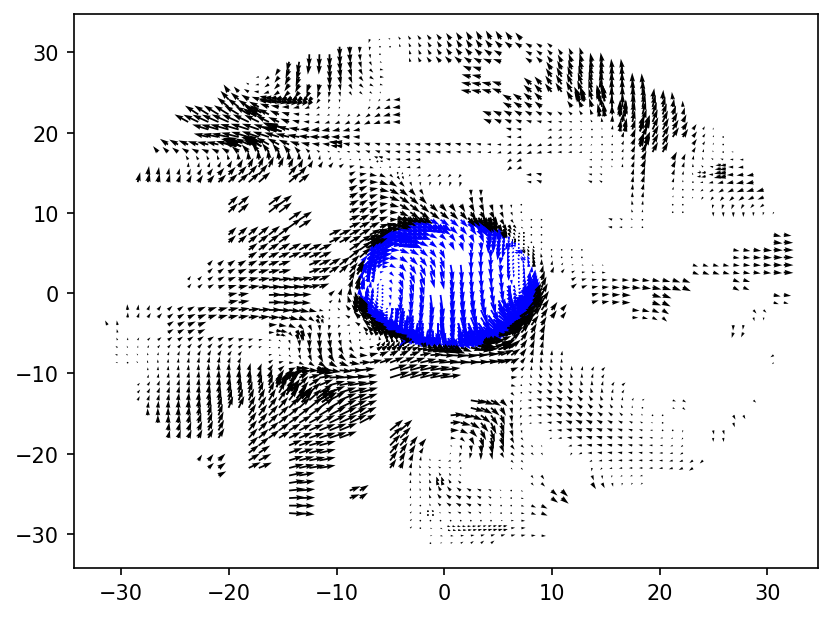

In [282]:
fig = plt.figure(dpi=150)
plt.quiver(vit_in[:,1][mask_vit_in_2d],vit_in[:,2][mask_vit_in_2d],vit_in[:,4][mask_vit_in_2d],vit_in[:,5][mask_vit_in_2d],color='b')
plt.quiver(vit_out[:,0][mask_vit_out_2d],vit_out[:,1][mask_vit_out_2d],vit_out[:,3][mask_vit_out_2d],vit_out[:,4][mask_vit_out_2d])
plt.scatter(interf[:,1][maskinterf2d],interf[:,2][maskinterf2d],color='r',s=0.5)

In [283]:
voronoi_kdtree = cKDTree(interf[:, 1:4]) #fonction qui trace un diagramme de Voronoi. 
#Ce diagrame permet de crée des régions où sont regorupés tout les points les points proches 
#d'un point de l'interface. Ça permet de calculer la distance des points à l'interface

In [284]:
test_point_dist_vit_out, test_point_regions_vit_out = voronoi_kdtree.query(vit_out[:, 0:3][mask_vit_out])
test_point_dist_vit_in, test_point_regions_vit_in = voronoi_kdtree.query(vit_in[mask_vit_in][:, 1:4])

In [11]:
def calculate_vit_in(vit_in,region_index,interface): # calcul de la vitesse normale et des vitesses tangentielles pour 
#un array de vitesse en cartésien à l'interieur de la bulle + gradient normal et tangentielles

    normale = interface[region_index][:,7:10]
    norm=np.sqrt(np.sum(normale[:,:]**2,axis=1))
    normale[:,:] /= norm[:,np.newaxis]
    tangente1, tangente2 = np.zeros([len(normale),3]), np.zeros([len(normale),3])
    i=0
    for v in normale:
        tangente1[i,:], tangente2[i,:] = calculate_orthogonal_vectors(v)
        i+=1

    scal=np.zeros(len(vit_in))
    scal2=np.zeros(len(vit_in))
    scal3=np.zeros(len(vit_in))
    v_norm_in= np.zeros([len(vit_in),9])
    v_tang1_in= np.zeros([len(vit_in),9])
    v_tang2_in= np.zeros([len(vit_in),9])

    # normale=interf[region_index][:,7:10]

    scal[:]=np.sum(normale[:,0:]*vit_in[:,4:7],axis=1) #produit scalaire entre la normale et la vitesse
    scal2[:]=np.sum(tangente1[region_index][:,0:]*vit_in[:,4:7],axis=1)
    scal3[:]=np.sum(tangente2[region_index][:,0:]*vit_in[:,4:7],axis=1)


    #on recopie les coordonées du point
    v_norm_in[:,0:4]=vit_in[:,0:4]
    v_tang1_in[:,0:4]=vit_in[:,0:4]
    v_tang2_in[:,0:4]=vit_in[:,0:4]
    #calcul de vn
    v_norm_in[:,4]=scal[:]*normale[:,0] # vn = (v,normale)*normale
    v_norm_in[:,5]=scal[:]*normale[:,1]
    v_norm_in[:,6]=scal[:]*normale[:,2]
    #calcul de vt1
    # v_tang_in[:, 4:7] = vit_in[:, 4:7] - v_norm_in[:, 4:7] # vt = v - vn 
    v_tang1_in[:,4]=scal2[:]*tangente1[region_index][:,0]
    v_tang1_in[:,5]=scal2[:]*tangente1[region_index][:,1]
    v_tang1_in[:,6]=scal2[:]*tangente1[region_index][:,2]
    #calcul de vt1
    v_tang2_in[:,4]=scal3[:]*tangente2[region_index][:,0]
    v_tang2_in[:,5]=scal3[:]*tangente2[region_index][:,1]
    v_tang2_in[:,6]=scal3[:]*tangente2[region_index][:,2]
    #on ajoute les normes 
    v_norm_in[:,7]=np.sqrt(v_norm_in[:,4]**2+v_norm_in[:,5]**2+v_norm_in[:,6]**2)
    v_tang1_in[:,7]=np.sqrt(v_tang1_in[:,4]**2+v_tang1_in[:,5]**2+v_tang1_in[:,6]**2)
    v_tang1_in[:,7]=np.sqrt(v_tang2_in[:,4]**2+v_tang2_in[:,5]**2+v_tang2_in[:,6]**2)
    #on met le volume de la cellule de calcul associé
    v_norm_in[:,-1]=vit_in[:,-1][mask_vit_in]
    v_tang1_in[:,-1]=vit_in[:,-1][mask_vit_in]
    v_tang2_in[:,-1]=vit_in[:,-1][mask_vit_in]
    
    #calcul des projections du gradient de vitesse 
    
    gradv_n_in=np.zeros([len(vit_in),5])
    gradv_n_in[:,0]=np.sum(vit_in[:,7:10]*normale[:,0:],axis=1)
    gradv_n_in[:,1]=np.sum(vit_in[:,10:13]*normale[:,0:],axis=1)
    gradv_n_in[:,2]=np.sum(vit_in[:,13:-1]*normale[:,0:],axis=1)
    gradv_n_in[:,3]=np.sum(gradv_n_in[:,0:3]**2,axis=1)
    gradv_n_in[:,-1]=vit_in[:,-1]

    gradv_t1_in=np.zeros([len(vit_in),5])
    gradv_t1_in[:,0]=np.sum(vit_in[:,7:10]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,1]=np.sum(vit_in[:,10:13]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,2]=np.sum(vit_in[:,13:-1]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,3]=np.sum(gradv_t1_in[:,0:3]**2,axis=1)
    gradv_t1_in[:,-1]=vit_in[:,-1]

    gradv_t2_in=np.zeros([len(vit_in),5])
    gradv_t2_in[:,0]=np.sum(vit_in[:,7:10]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,1]=np.sum(vit_in[:,10:13]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,2]=np.sum(vit_in[:,13:-1]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,3]=np.sum(gradv_t2_in[:,0:3]**2,axis=1)
    gradv_t2_in[:,-1]=vit_in[:,-1]
    
    return v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in

In [12]:
def calculate_vit_out(vit_out,region_index,interface): # calcul de la vitesse normale et des vitesses tangentielles pour 
#un array de vitesse en cartésien à l'interieur de la bulle


    normale = calculate_normale(vit_out[:,0:3],interface[:,1:4],region_index)
    tangente1, tangente2 = np.zeros([len(normale),3]), np.zeros([len(normale),3])
    i=0
    for v in normale:
        tangente1[i,:], tangente2[i,:] = calculate_orthogonal_vectors(v)
        i+=1
    n = len(vit_out)
    scal=np.zeros(n)
    scal2=np.zeros(n)
    scal3=np.zeros(n)
    v_norm_out= np.zeros([n,8])
    v_tang1_out= np.zeros([n,8])
    v_tang2_out= np.zeros([n,8])

    scal[:]=np.sum(normale[:,0:]*vit_out[:,3:6],axis=1) #produit scalaire entre la normale et la vitesse
    scal2[:]=np.sum(tangente1[region_index][:,0:]*vit_out[:,3:6],axis=1)
    scal3[:]=np.sum(tangente2[region_index][:,0:]*vit_out[:,3:6],axis=1)

    #on recopie les coordonées du point
    v_norm_out[:,0:3]=vit_out[:,0:3]
    v_tang1_out[:,0:3]=vit_out[:,0:3]
    v_tang2_out[:,0:3]=vit_out[:,0:3]
    #calcul de vn
    v_norm_out[:,3]=scal[:]*normale[:,0] # vn = (v,normale)*normale
    v_norm_out[:,4]=scal[:]*normale[:,1]
    v_norm_out[:,5]=scal[:]*normale[:,2]
    # v_norm_out[:,3:6]=scal*normale
    #calcul de vt1
    # v_tang_out[:, 3:6] = vit_out[:, 3:6] - v_norm_out[:, 3:6] 
    v_tang1_out[:,3]=scal2[:]*tangente1[region_index][:,0]
    v_tang1_out[:,4]=scal2[:]*tangente1[region_index][:,1]
    v_tang1_out[:,5]=scal2[:]*tangente1[region_index][:,2]
    #calcul de vt1
    # v_tang_out[:, 3:6] = vit_out[:, 3:6] - v_norm_out[:, 3:6] 
    v_tang2_out[:,3]=scal3[:]*tangente1[region_index][:,0]
    v_tang2_out[:,4]=scal3[:]*tangente1[region_index][:,1]
    v_tang2_out[:,5]=scal3[:]*tangente1[region_index][:,2]
    #on ajoute les normes 
    v_norm_out[:,6]=np.sqrt(np.sum(v_norm_out[:,3:6]**2,axis=1))
    v_tang1_out[:,6]=np.sqrt(np.sum(v_tang1_out[:,3:6]**2,axis=1))
    v_tang2_out[:,6]=np.sqrt(np.sum(v_tang2_out[:,3:6]**2,axis=1))
    #on met le volume de la cellule de calcul associé
    v_norm_out[:,-1]=vit_out[:,-1]
    v_tang1_out[:,-1]=vit_out[:,-1]
    v_tang2_out[:,-1]=vit_out[:,-1]
    
    gradv_n_out=np.zeros([n,5])
    gradv_n_out[:,0]=np.sum(vit_out[:,6:9]*normale[:,0:],axis=1)
    gradv_n_out[:,1]=np.sum(vit_out[:,9:12]*normale[:,0:],axis=1)
    gradv_n_out[:,2]=np.sum(vit_out[:,12:-1]*normale[:,0:],axis=1)
    gradv_n_out[:,3]=np.sum(gradv_n_out[:,0:3]**2,axis=1)
    gradv_n_out[:,-1]=vit_out[:,-1]

    gradv_t1_out=np.zeros([n,5])
    gradv_t1_out[:,0]=np.sum(vit_out[:,6:9]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,1]=np.sum(vit_out[:,9:12]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,2]=np.sum(vit_out[:,12:-1]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,3]=np.sum(gradv_t1_out[:,0:3]**2,axis=1)
    gradv_t1_out[:,-1]=vit_out[:,-1]

    gradv_t2_out=np.zeros([n,5])
    gradv_t2_out[:,0]=np.sum(vit_out[:,6:9]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,1]=np.sum(vit_out[:,9:12]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,2]=np.sum(vit_out[:,12:-1]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,3]=np.sum(gradv_t2_out[:,0:3]**2,axis=1)
    gradv_t2_out[:,-1]=vit_out[:,-1]

    
    return v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out

In [147]:
def calculate_vit_interf(vit_interface,interface):
    
    norm = np.sum(interface[:,7:10],axis=1)
    interface[:,7:10]/=norm[:,np.newaxis]
    tangente1, tangente2 = np.zeros([len(interface),3]), np.zeros([len(interface),3])
    i = 0
    for elem in interface:
        tangente1[i],tangente2[i] = calculate_orthogonal_vectors(interface[i,7:10])
        i+=1
    n = len(vit_interf)
    vn_interf = 0
    vt1_interf = 0
    vt2_interf = 0

    vn_interf = np.sum(np.sum(vit_interface[:,4:7]*interface[:,7:10],axis=1)**2/len(interface))
    vt1_interf = np.sum(np.sum(vit_interface[:,4:7]*tangente1[:,:],axis=1)**2/len(interface))
    vt2_interf = np.sum(np.sum(vit_interface[:,4:7]*tangente2[:,:],axis=1)**2/len(interface))
    
    return vn_interf, vt1_interf, vt2_interf
    
    

In [148]:
vn_interf, vt1_interf, vt2_interf = calculate_vit_interf(vit_interf[mask_vit_interf],interf[maskinterf])
print(vn_interf, vt1_interf, vt2_interf)

12335766.456729284 44.5958841328164 44.987467102122224


In [302]:
v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in = calculate_vit_in(vit_in[mask_vit_in],test_point_regions_vit_in,interf)
v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out = calculate_vit_out(vit_out[mask_vit_out],test_point_regions_vit_out,interf)

In [ ]:
#test de la normalisation avec une fonction exponentielle
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_vit_out -dist[:, np.newaxis], sig)

expo=np.exp(test_point_dist_vit_out)

mean = np.sum(expo*weights*vit_out[:, -1][mask_vit_out], axis=1)/np.sum(vit_out[:, -1][mask_vit_out]*weights, axis=1)


In [ ]:
plt.figure(dpi=150)
plt.plot(dist[:-20],mean[:-20],label='interpolation')
plt.xlabel('$d$')
plt.ylabel('$exp(d)$')
plt.plot(dist[:-20],np.exp(dist[:-20]),color='r',linestyle='--',label='exp')
plt.title('test normalisation avec une fonction exponentielle')
plt.legend()
plt.savefig(folderfig+'test_normalisation.pdf')
print(mean[0])

In [303]:
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_vit_out -dist[:, np.newaxis], sig)

vn_out = np.sum(v_norm_out[:, 6]*weights*v_norm_out[:, -1], axis=1)/np.sum(v_norm_out[:, -1]*weights,axis=1)
vt1_out = np.sum(v_tang1_out[:, 6]*weights*v_tang1_out[:, -1], axis=1)/np.sum(v_tang1_out[:, -1]*weights,axis=1)
vt2_out = np.sum(v_tang2_out[:, 6]*weights*v_tang2_out[:, -1], axis=1)/np.sum(v_tang2_out[:, -1]*weights,axis=1)
gvn_out = np.sum(gradv_n_out[:, -2]*weights*gradv_n_out[:, -1], axis=1)/np.sum(gradv_n_out[:, -1]*weights,axis=1)
gvt1_out = np.sum(gradv_t1_out[:, -2]*weights*gradv_t1_out[:, -1], axis=1)/np.sum(gradv_t1_out[:, -1]*weights,axis=1)
gvt2_out = np.sum(gradv_t2_out[:, -2]*weights*gradv_t2_out[:, -1], axis=1)/np.sum(gradv_t2_out[:, -1]*weights,axis=1)

weights = gaussian(test_point_dist_vit_in -dist[:, np.newaxis], sig)
norm=np.sum(v_norm_in[:, -1]*weights,axis=1)
vn_in = np.sum(v_norm_in[:, 7]*weights*v_norm_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
norm=np.sum(v_tang1_in[:, -1]*weights,axis=1)
vt1_in = np.sum(v_tang1_in[:, 7]*weights*v_tang1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
norm=np.sum(v_tang2_in[:, -1]*weights,axis=1)
vt2_in = np.sum(v_tang2_in[:, 7]*weights*v_tang2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
norm=np.sum(gradv_n_in[:, -1]*weights,axis=1)
gvn_in = np.sum(gradv_n_in[:, -2]*weights*gradv_n_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
norm=np.sum(gradv_t1_in[:, -1]*weights,axis=1)
gvt1_in = np.sum(gradv_t1_in[:, -2]*weights*gradv_t1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
norm=np.sum(gradv_t2_in[:, -1]*weights,axis=1)
gvt2_in = np.sum(gradv_t2_in[:, -2]*weights*gradv_t2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)

/tmp/ipykernel_21088/3163525357.py:5: RuntimeWarning: invalid value encountered in divide
  vn_out = np.sum(v_norm_out[:, 6]*weights*v_norm_out[:, -1], axis=1)/np.sum(v_norm_out[:, -1]*weights,axis=1)
/tmp/ipykernel_21088/3163525357.py:6: RuntimeWarning: invalid value encountered in divide
  vt1_out = np.sum(v_tang1_out[:, 6]*weights*v_tang1_out[:, -1], axis=1)/np.sum(v_tang1_out[:, -1]*weights,axis=1)
/tmp/ipykernel_21088/3163525357.py:7: RuntimeWarning: invalid value encountered in divide
  vt2_out = np.sum(v_tang2_out[:, 6]*weights*v_tang2_out[:, -1], axis=1)/np.sum(v_tang2_out[:, -1]*weights,axis=1)
/tmp/ipykernel_21088/3163525357.py:8: RuntimeWarning: invalid value encountered in divide
  gvn_out = np.sum(gradv_n_out[:, -2]*weights*gradv_n_out[:, -1], axis=1)/np.sum(gradv_n_out[:, -1]*weights,axis=1)
/tmp/ipykernel_21088/3163525357.py:9: RuntimeWarning: invalid value encountered in divide
  gvt1_out = np.sum(gradv_t1_out[:, -2]*weights*gradv_t1_out[:, -1], axis=1)/np.sum(gradv_t1_

In [301]:
vt2_in

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 1.0, '$v_t^2$-$v_n^2$ outside ratio - single simu')

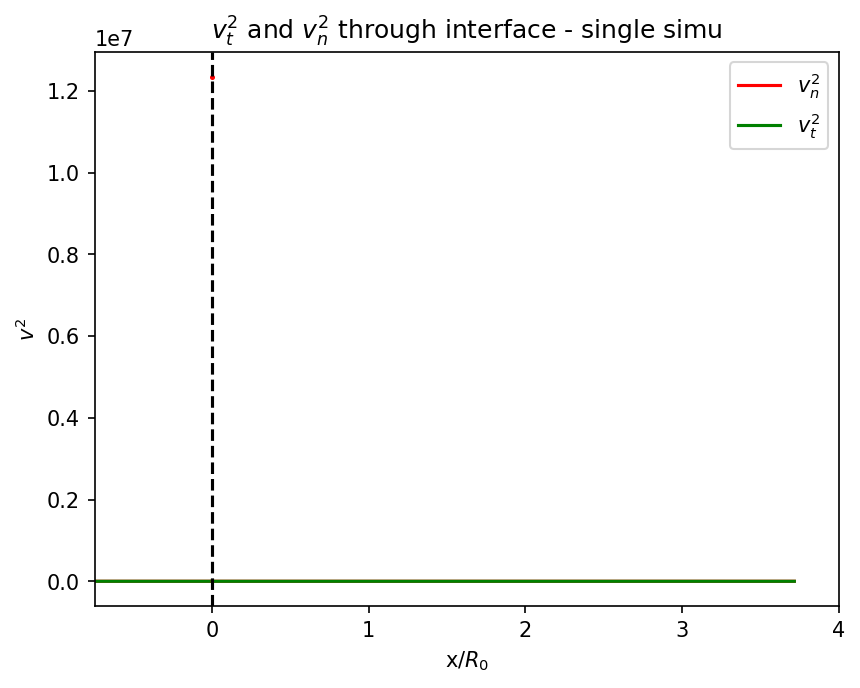

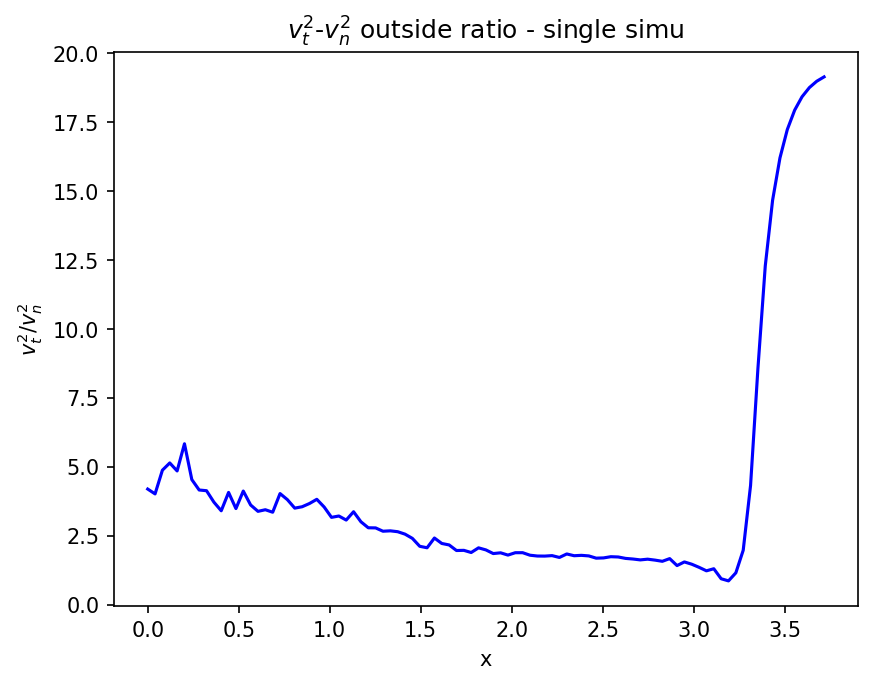

In [304]:

plt.figure(dpi=150)
plt.plot((dist/R0)*(-1),vn_in**2,color='r',label='$v_n^2$')
plt.plot((dist/R0)*(-1),(vt1_in**2+vt2_in**2)/2,color='g',label='$v_t^2$')
plt.plot((dist/R0),vn_out**2,color='r')
plt.plot((dist/R0),(vt1_out**2+vt2_out**2)/2,color='g')
plt.legend()
plt.xlabel('x/$R_0$')
plt.ylabel('$v^2$')
plt.axvline(0,color='k',linestyle='--')
plt.title('$v_t^2$ and $v_n^2$ through interface - single simu')
plt.xlim(-0.75,4)
# plt.savefig( folderfig + 'vn_vt_single_simu')
plt.scatter(0,vn_interf,color='r',s=2)
# plt.axhline(np.mean((vt1_out[25:]**2+vt2_out[25:]**2)/2))
plt.figure(dpi=150)

plt.plot(dist/R0,((vt1_out**2+vt2_out**2)/vn_out**2),color='b')
# plt.plot((dist/R0)*(-1),((vt1_in**2+vt2_in**2)/vn_in**2),color='b')
plt.axhline(np.mean((vt1_out[15:]**2+vt2_out[15:]**2)/vn_out[15:]**2),color='k')
plt.xlabel('x')
plt.ylabel('$v_t^2$/$v_n^2$')
plt.title('$v_t^2$-$v_n^2$ outside ratio - single simu')

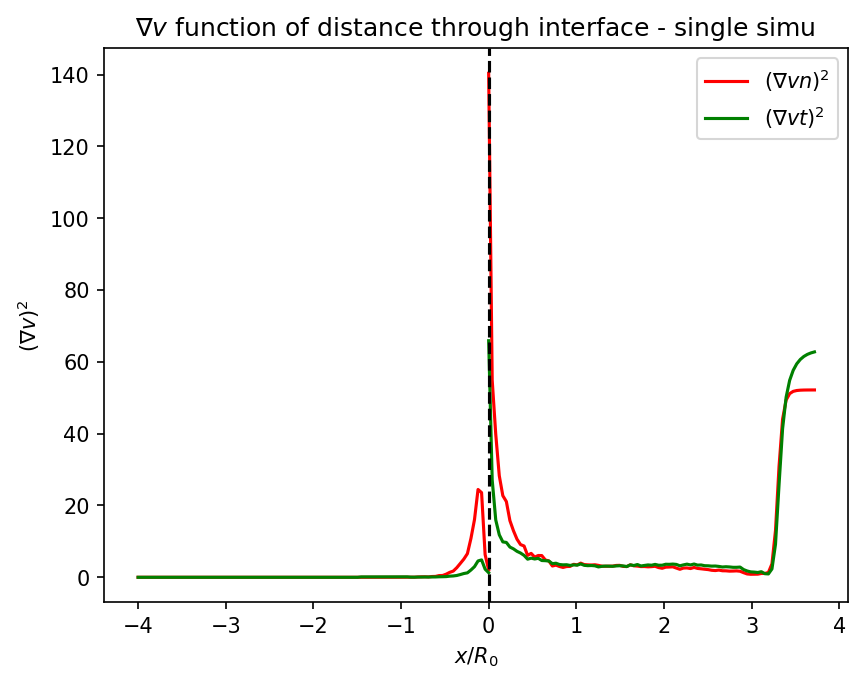

In [171]:


plt.figure(dpi=150)
plt.plot((dist/R0)*(-1),gvn_in**2/25,color='r',label=r'$(\nabla vn)^2$')
plt.plot((dist/R0)*(-1),(gvt1_in**2+gvt2_in**2)/2/25,color='g',label=r'$(\nabla vt)^2$')
plt.plot((dist/R0),gvn_out**2,color='r')
plt.plot((dist/R0),(gvt1_out**2+gvt2_out**2)/2,color='g')
plt.xlabel(r'$x/R_0$')
plt.ylabel(r'$(\nabla v)^2$')
plt.title(r'$\nabla v$ function of distance through interface - single simu ')
plt.axvline(0,color='k',linestyle='--')
plt.legend()
# plt.savefig( folderfig + 'gvn_gvt_single_simu')
# plt.axhline(np.mean((gvt1_out[15:]**2+gvt2_out[15:]**2)/2),linestyle='--')

In [154]:
print(vn_in,vt1_in,vt2_in,vn_out,vt1_out,vt2_out)

[1.87079677 1.89287881 1.91909307 1.95115873 2.00973684 2.12571275
 2.30801376 2.53046859 2.7542672  2.95767509 3.14031117 3.29944502
 3.41777005 3.49207935 3.55470734 3.6465643  3.76407539 3.85326246
 3.89227299 3.93500006 4.03677681 4.16526068 4.22671573 4.19904813
 4.17071112 4.20921085 4.28654249 4.36201559 4.43861971 4.50183937
 4.51280621 4.48846573 4.47309713 4.47015082 4.4938238  4.56821133
 4.61871892 4.56503635 4.45911179 4.40753458 4.48330567 4.6740603
 4.86662116 4.95041645 4.87952457 4.69236145 4.52185567 4.47513118
 4.53190315 4.58067671 4.58974167 4.61093112 4.62253106 4.54142846
 4.3695183  4.2294567  4.22487377 4.29305286 4.29560544 4.18508915
 4.07747693 4.14129766 4.37287097 4.59338408 4.59402875 4.34419283
 4.10719781 4.07579946 4.10977868 3.99065354 3.70655607 3.4291004
 3.25746114 3.20893633 3.22050649 3.11777379 2.91552532 2.82525781
 2.97246298 3.22092383 3.37369357 3.42649131 3.43388268 3.42606533
 3.41452841 3.40316732 3.39317317 3.38479197 3.37794043 3.372428

In [15]:
def loadfiles(filename):
    '''
    Load vitessein, vitesseout, vitesseinterf and interface files knowing the folder direction. 
    Return velocity fields arrays
    '''
    import warnings

    with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
        warnings.simplefilter("ignore")    

        filesinterf = glob.glob(filename + '/inter*.dat')
        
        interf = np.zeros([0, 10], dtype=float)
        bubble = np.zeros([0,12], dtype=float)
        vit_in = np.zeros([0,15], dtype=float)
        vit_interf = np.zeros([0,15], dtype=float)
        vit_out = np.zeros([0,15], dtype=float)
        
        for file in filesinterf:
            datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                interf = np.vstack((interf, datatemp))
        
        datatemp=np.loadtxt(filename + '/bubbles.dat',skiprows=1)
        if datatemp.shape !=(0,):
                bubble = np.vstack((bubble,datatemp))

        vit_in=np.loadtxt(filename + '/vitessein_0.dat',skiprows=1)

        vit_interf=np.loadtxt(filename + '/vitesseinterf_0.dat',skiprows=1)

        vit_out=np.loadtxt(filename + '/vitesseout_0.dat',skiprows=1)


        return interf, bubble, vit_in, vit_interf, vit_out

In [228]:
dist = np.linspace(0, 8, 100)  
dist2 = np.linspace(0, 32, 500) 
vitesseext = {}
vitesseint = {}
# vitesseinterf = {}
occ_gamma_dump={}


for fold in folds:
    
    interf, bubble, vit_in, vit_interf, vit_out = loadfiles(fold);
    #test whether the bubble broke or not. If so there are several bubbles and so 
    # bubble number can be larger than 0. 
    print(fold)
    if 1 in vit_in[:, 0]:
        print('break')
        print(np.max(vit_in[:, 0]))
        continue
    

    #recenter

#     point intérieurs
    maskinterf=(interf[:,0]>-1)
    mask_vit_in=(vit_in[:,0]<600)
    mask_vit_interf=(vit_interf[:,0]<600)

#     print(bubble)
    for bulle in bubble:
        if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
            j=bulle[2]
            maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
            mask_vit_in=np.logical_and(mask_vit_in,vit_in[:,0][:]!=j)
            mask_vit_interf=np.logical_and(mask_vit_interf,vit_interf[:,0][:]!=j)
    # on recentre les points
    pc = np.median(vit_in[mask_vit_in][:,1:4])
    interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position
    vit_in[:, 1:4] = np.mod(vit_in[:, 1:4] - pc + L/2, L) - L/2 #shift data position
    vit_interf[:, 1:4] = np.mod(vit_interf[:, 1:4] - pc + L/2, L) - L/2 #shift data position
    vit_out[:, 0:3] = np.mod(vit_out[:, 0:3] - pc + L/2, L) - L/2 #shift data position
    #compute distance
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interf[maskinterf][:,1:4])
    #Region of the test points
    test_point_dist, test_regions_vit = voronoi_kdtree.query(vit_in[:,1:4][mask_vit_in])
#     mask_vit_in = np.logical_and(mask_vit_in,positif)

    
    v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in = calculate_vit_in(vit_in[mask_vit_in],test_regions_vit,interf)


    weights = gaussian(test_point_dist -dist[:, np.newaxis], sig)

    norm=np.sum(v_norm_in[:, -1]*weights,axis=1)
    vn_in = np.sum(v_norm_in[:, 7]*weights*v_norm_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(v_tang1_in[:, -1]*weights,axis=1)
    vt1_in = np.sum(v_tang1_in[:, 7]*weights*v_tang1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(v_tang2_in[:, -1]*weights,axis=1)
    vt2_in = np.sum(v_tang2_in[:, 7]*weights*v_tang2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_n_in[:, -1]*weights,axis=1)
    gvn_in = np.sum(gradv_n_in[:, -2]*weights*gradv_n_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_t1_in[:, -1]*weights,axis=1)
    gvt1_in = np.sum(gradv_t1_in[:, -2]*weights*gradv_t1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_t2_in[:, -1]*weights,axis=1)
    gvt2_in = np.sum(gradv_t2_in[:, -2]*weights*gradv_t2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    
    if float(fold.split('-')[2])==8:
        gamma = float(fold.split('-')[3])
    else:
        gamma = float(fold.split('-')[2])
    
    if gamma not in vitesseint:
        vitesseint[gamma] = np.zeros([7, len(dist)])
        occ_gamma_dump[gamma] = 0

    ind = dist<np.max(test_point_dist) 
    ind = np.logical_and(ind, vn_in>0)
    
    vitesseint[gamma][0, :][ind] += vn_in[ind]
    vitesseint[gamma][1, :][ind] += vt1_in[ind]
    vitesseint[gamma][2, :][ind] += vt2_in[ind]
    vitesseint[gamma][3, :][ind] += gvn_in[ind]
    vitesseint[gamma][4, :][ind] += gvt1_in[ind]
    vitesseint[gamma][5, :][ind] += gvt2_in[ind]
    vitesseint[gamma][6,:][ind] += 1
    
    occ_gamma_dump[gamma] += 1
    
    with open( fold +  '/vitint.pkl', 'wb') as f:
        pickle.dump(vitesseint, f)
        
    #     points extérieurs
    pc=np.mean(vit_in[:,1:4], axis=0)
    mask_vit_out=((vit_out[:,0]-pc[0])**2+(vit_out[:,1]-pc[1])**2+(vit_out[:,2]-pc[2])**2<((5*8)**2)) #4*R0
    #compute distance
    distpoints_vit, test_regions_vit = voronoi_kdtree.query(vit_out[:,0:3][mask_vit_out])
    
    v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out = calculate_vit_out(vit_out[mask_vit_out],test_regions_vit,interf)
    
    weights = gaussian(distpoints_vit -dist2[:, np.newaxis], sig)

    norm = np.sum(v_norm_out[:, -1]*weights,axis=1)
    vn_out = np.sum(v_norm_out[:, 6]*weights*v_norm_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(v_tang1_out[:, -1]*weights,axis=1)
    vt1_out = np.sum(v_tang1_out[:, 6]*weights*v_tang1_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(v_tang2_out[:, -1]*weights,axis=1)
    vt2_out = np.sum(v_tang2_out[:, 6]*weights*v_tang2_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_n_out[:, -1]*weights,axis=1)
    gvn_out = np.sum(gradv_n_out[:, -2]*weights*gradv_n_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_t1_out[:, -1]*weights,axis=1)
    gvt1_out = np.sum(gradv_t1_out[:, -2]*weights*gradv_t1_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_t2_out[:, -1]*weights,axis=1)
    gvt2_out = np.sum(gradv_t2_out[:, -2]*weights*gradv_t2_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)

    
    if gamma not in vitesseext:
        vitesseext[gamma] = np.zeros([7, len(dist2)])


    ind = dist2<np.max(distpoints_vit) 
    ind = np.logical_and(ind, vn_out > 0)
    vitesseext[gamma][0, :][ind] += vn_out[ind]
    vitesseext[gamma][1, :][ind] += vt1_out[ind]
    vitesseext[gamma][2, :][ind] += vt2_out[ind]
    vitesseext[gamma][3, :][ind] += gvn_out[ind]
    vitesseext[gamma][4, :][ind] += gvt1_out[ind]
    vitesseext[gamma][5, :][ind] += gvt2_out[ind]
    vitesseext[gamma][6,:][ind] += 1
    
    with open( fold +  '/vitext.pkl', 'wb') as f:
        pickle.dump(vitesseext, f)
    
for tab in [vitesseext,vitesseint]:
    for key in tab:
        tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)
        


Re55t140-l9-8-3000-dump_44902-dump_44902
Re55t140-l9-8-3000-2-dump_1-dump_1
Re55t200-l9-1750-4-dump
Re55t140-l9-8-560-2-dump_59013-dump_59013
Re55t200-l9-1120-2-dump
Re55t200-l9-1120-4-dump
Re55t140-l9-8-2240-2-dump_83039
Re55t140-l9-400-3end-dump
Re55t200-l9-1120-5end-dump
Re55t140-l9-8-2240-dump_51678
Re55t140-l9-8-2240-2-dump_70499-dump_70499
Re55t180-l9-1120-5end-dump
Re55t120-l9-1120-2-dump
Re55t140-l9-8-2240-4-dump_111276-dump_111276
Re55t180-l9-1120-4-dump
Re55t140-l9-8-2240-3-dump_1-dump_1
Re55t140-l9-8-2240-2-dump_57959
Re55t140-l9-8-1750-dump_32018
Re55t140-l9-8-560-dump_37051-dump_37051
Re55t140-l9-2240-dump_0-dump_0
Re55t140-l9-8-2240-4-dump_123816-dump_123816
Re55t120-l9-8-400-dump_27098-dump_27098
Re55t140-l9-2240-dump_54813-dump_54813
Re55t200-l9-560-2-dump
Re55t140-l9-8-800-dump_52413-dump_52413
Re55t140-l9-8-2240-4-dump_1-dump_1
Re55t140-l9-8-2240-4-dump_114411
Re55t140-l9-8-2240-2-dump_76769
Re55t120-l9-400-dump_37759-dump_37759
Re55t120-l9-8-400-dump_40409
Re55t140-l

Re55t140-l9-8-3000-2-dump_70309-dump_70309
Re55t140-l9-8-2240-4-dump_130086-dump_130086
Re55t140-l9-8-3000-dump_1-dump_1
Re55t140-l9-8-2240-4-dump_120681-dump_120681
Re55t140-l9-8-560-dump_33915-dump_33915
Re55t140-l9-8-3000-4-dump_121122-dump_121122
Re55t140-l9-2240-dump_42273-dump_42273
Re55t200-l9-1120-3-dump
Re55t120-l9-400-dump_43067-dump_43067
Re55t120-l9-8-400-dump_40409-dump_40409
Re55t160-l9-275-dump
break
2.0
Re55t140-l9-2240-dump_51678-dump_51678
Re55t140-l9-8-560-2-dump_69997-dump_69997
Re55t120-l9-8-400-dump_28423
Re55t200-l9-2240-3-dump
Re55t140-l9-8-560-2-dump_74701-dump_74701
Re55t160-l9-2240-5-dump
Re55t140-l9-1120-4end-dump
Re55t140-l9-8-2240-dump_48543
Re55t120-l9-8-400-2-dump_51118-dump_51118
Re55t140-l9-8-2240-4-dump_1
Re55t120-l9-8-400-2-dump_55112-dump_55112
Re55t140-l9-8-800-3-dump_1-dump_1
Re55t200-l9-560-3-dump
Re55t120-l9-8-400-2-dump_1
Re55t140-l9-8-2240-3-dump_98725-dump_98725
Re55t160-l9-2240-3-dump
Re55t160-l9-3000-3-dump
Re55t120-l9-8-400-2-dump_57762-du

In [86]:
np.isnan(vn_in)==False

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [229]:
lgammas = []
for key in vitesseint:
    lgammas.append(key)
print(lgammas)
gamma_sort=np.sort(lgammas)
print(gamma_sort)
# lgammas = np.sort(lgammas)
we=[]

print(lgammas[1],pref/8)
for i in np.arange(8):
    w=pref/gamma_sort[i]

    we.append(w)
we=np.sort(we)
print(we)

[3000.0, 1750.0, 560.0, 1120.0, 2240.0, 400.0, 800.0, 275.0]
[ 275.  400.  560.  800. 1120. 1750. 2240. 3000.]
1750.0 99.89330486864284
[0.26638215 0.3567618  0.45665511 0.71352361 0.99893305 1.42704721
 1.9978661  2.90598705]


In [359]:

i=0
somme=0
for key in occ_gamma_dump:
    print( key, occ_gamma_dump[key])
    somme+= occ_gamma_dump[key]
    i+=1
print(somme)


3000.0 52
1750.0 24
560.0 46
1120.0 27
2240.0 106
400.0 105
800.0 48
275.0 6
414


In [45]:
    
# for tab in [vitesseext]:
#     for key in tab:
#         tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)
#         tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)
        
# for tab in [vitesseint]:
#     for key in tab:
#         tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)
#         tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)

/tmp/ipykernel_21088/860354078.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0.5, 1.0, '$V_n^2$ through interface for different $W_e$')

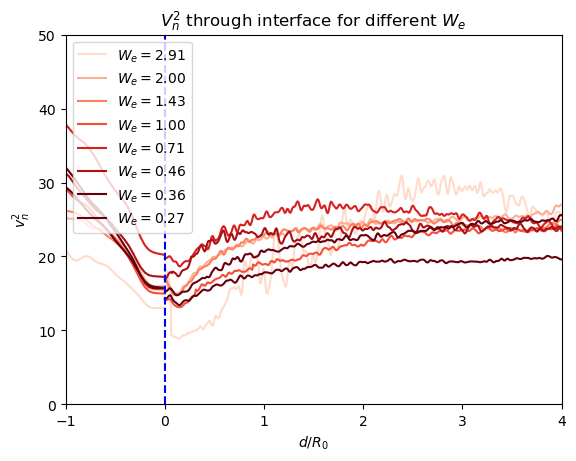

In [344]:


cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in gamma_sort:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/8, vitesseint[key][0,:]**2,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    line, = plt.plot(dist2/8, vitesseext[key][0,:]**2,color=cmap(i+1))
    i+=1
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$v_n^2$')
plt.axvline(0,color='b',linestyle='--')
plt.xlim(-1,4)
plt.ylim(0,50)

plt.title('$V_n^2$ through interface for different $W_e$')
# plt.savefig( folderfig + 'vn**2_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/1374990346.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


{275.0: array([268]), 400.0: array([359]), 560.0: array([235]), 800.0: array([319]), 1120.0: array([112]), 1750.0: array([220]), 2240.0: array([364]), 3000.0: array([282])}


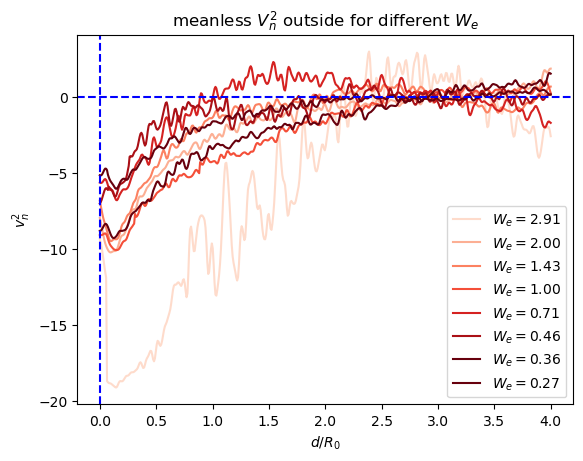

In [352]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
ind0 = {}
for key in gamma_sort:
    if key<700:
        pass
    moy = np.sum(vitesseext[key][0,250:]**2)/len(dist2[250:])
    line, = plt.plot(dist2/8, vitesseext[key][0,:]**2-moy,color=cmap(i+1), label = f'$W_e = {pref/key:.2f}$')
    j = np.argwhere(vitesseext[key][0,:]**2-moy>0)
    if key not in ind0:
        ind0[key] = j[0]
    i+=1
plt.legend()
print(ind0)
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$v_n^2$')
plt.axvline(0,color='b',linestyle='--')
plt.axhline(0,color='b',linestyle='--')
plt.title('meanless $V_n^2$ outside for different $W_e$')
# plt.xlim(-1,4)
# plt.ylim(0,50)
plt.savefig( folderfig + 'vn**2_out_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/3961185129.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0, 0.5, '$\\lambda_{v_n}/R_0$')

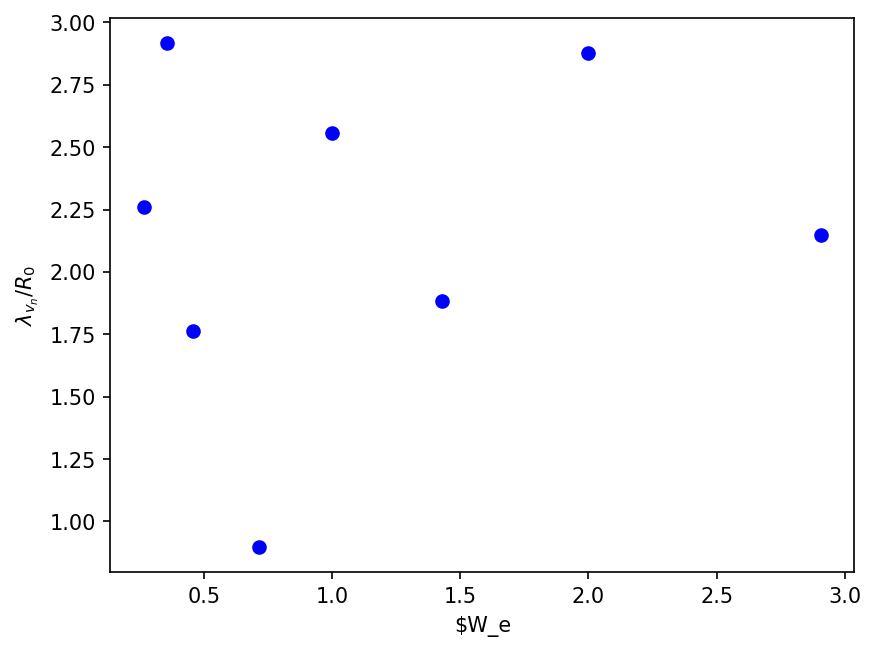

In [357]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
plt.figure(dpi=150)
for key in lgammas:
    plt.scatter(pref/key,dist2[ind0[key]]/R0,color='b')
    
plt.xlabel('$W_e')
plt.ylabel(r'$\lambda_{v_n}/R_0$')

/tmp/ipykernel_21088/4218962518.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


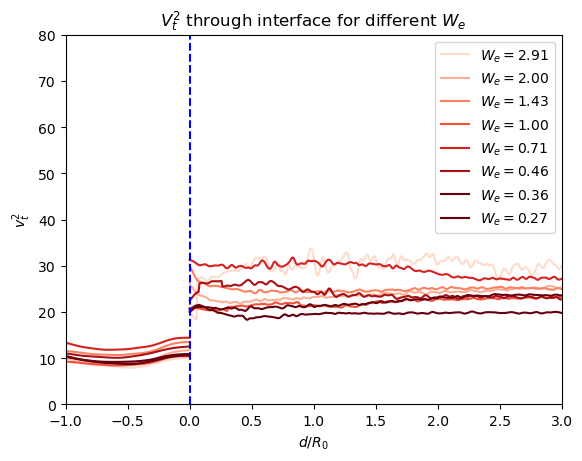

In [320]:


cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in gamma_sort:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/8, (vitesseint[key][1,:]**2+vitesseint[key][2,:]**2)/2,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    line, = plt.plot(dist2/8, (vitesseext[key][1,:]**2+vitesseext[key][2,:]**2)/2,color=cmap(i+1))
    i+=1
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$v_t^2$')
plt.axvline(0,color='b',linestyle='--')
plt.xlim(-1,3)
plt.ylim(0,80)

plt.title('$V_t^2$ through interface for different $W_e$')
plt.savefig( folderfig + 'vt**2_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/3200314204.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0.5, 1.0, '(($\\nabla v).n)^2$ for different $W_e$')

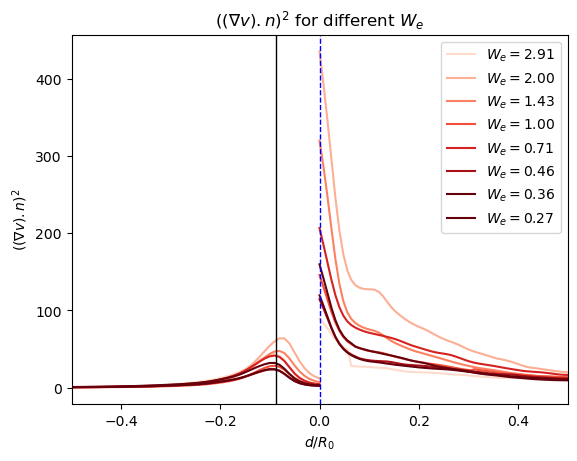

In [244]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in gamma_sort:
    if key<700:
        pass

    line, = plt.plot(dist*(-1)/R0, vitesseint[key][3,:]**2/25,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    line, = plt.plot(dist2/R0, vitesseext[key][3,:]**2,color=cmap(i+1))
    i+=1
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).n)^2$')
plt.xlim(-0.5,0.5)
plt.axvline(0,color='b',linestyle='--',lw=1)
plt.axvline(-3*dx/R0,color='k',lw=1) #deux cellules
plt.title(r'(($\nabla v).n)^2$ for different $W_e$')
# plt.savefig(folderfig + 'gradn**2_We')

/tmp/ipykernel_21088/4103547226.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


[241. 188. 233. 159. 182. 152.  86. 273.]


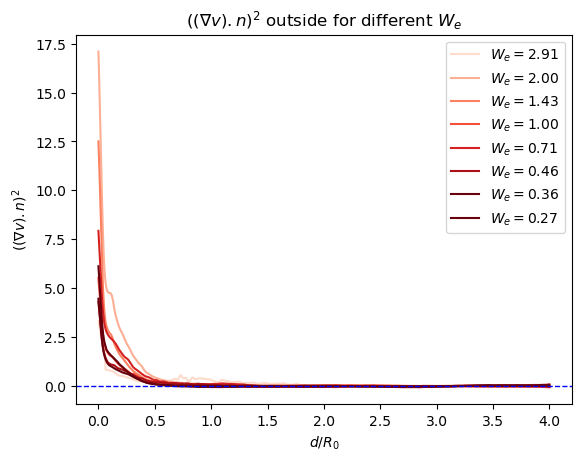

In [258]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
indice0 = np.zeros(len(gamma_sort))
for key in gamma_sort:
    if key<700:
        pass

    moy = np.sum(vitesseext[key][3,250:]**2)/len(dist2[250:])
    line, = plt.plot(dist2/R0, (vitesseext[key][3,:]**2-moy)/25,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    indice = np.argwhere(vitesseext[key][3,:]**2-moy<0)
    indice0[i]=indice[0]
    i+=1
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).n)^2$')
# plt.xlim(0,1)
# plt.ylim(-20,20)
print(indice0)
plt.axhline(0,color='b',linestyle='--',lw=1)
plt.title(r'(($\nabla v).n)^2$ outside for different $W_e$')
plt.savefig( folderfig + 'gradvn_out_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/3453429366.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


{275.0: array([0.08090591, 1.12675162, 0.36209575]), 400.0: array([0.10492363, 2.63425854, 0.41127542]), 560.0: array([0.072452  , 2.40075368, 0.36101529]), 800.0: array([0.12249423, 1.45716474, 0.34537207]), 1120.0: array([0.14535708, 1.78953179, 0.37108085]), 1750.0: array([0.13846176, 1.14780007, 0.29403972]), 2240.0: array([0.10509472, 1.25207674, 0.32153543]), 3000.0: array([0.10601083, 1.58850996, 0.28984068])}


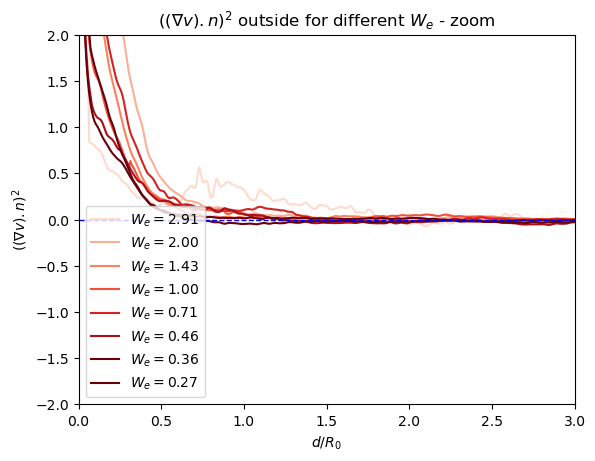

In [323]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
opti = {}
for key in gamma_sort:
    if key<700:
        pass
    
    moy = np.sum(vitesseext[key][3,250:]**2)/len(dist2[250:])
    line, = plt.plot(dist2/R0, (vitesseext[key][3,:]**2-moy)/25,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    popt, cov = curve_fit(expo_decr,dist2/R0,vitesseext[key][3,:]**2/25)
    if key not in opti:
        opti[key] = np.zeros(3)
        opti[key] = popt
    i+=1

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).n)^2$')
plt.xlim(0,3)
plt.ylim(-2,2)
print(opti)
plt.axhline(0,color='b',linestyle='--',lw=1)
plt.title(r'(($\nabla v).n)^2$ outside for different $W_e$ - zoom')
plt.savefig( folderfig + 'gradvn_out_We_zoom.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/1891299394.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0.5, 1.0, 'fit of exp function on outside $(\\nabla v).n$ for $\\gamma = 2240$ ')

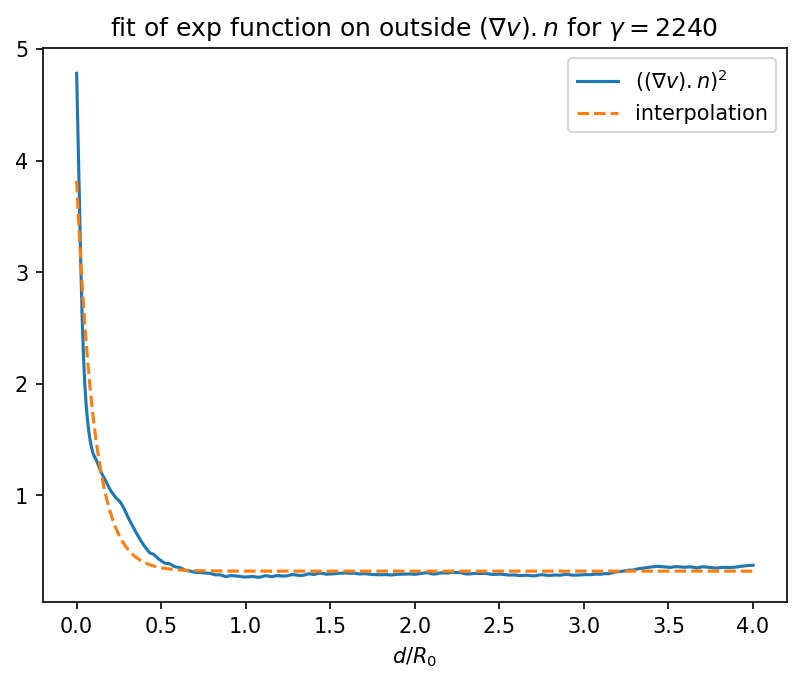

In [332]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
gam = 2240.
plt.figure(dpi=150)
plt.plot(dist2/R0,vitesseext[gam][3,:]**2/25,label=r'$((\nabla v).n)^2$')
plt.plot(dist2/R0,expo_decr(dist2/R0,opti[gam][0],opti[gam][1],opti[gam][2]),linestyle = '--', label='interpolation')
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.title(r'fit of exp function on outside $(\nabla v).n$ for $\gamma = 2240$ ')

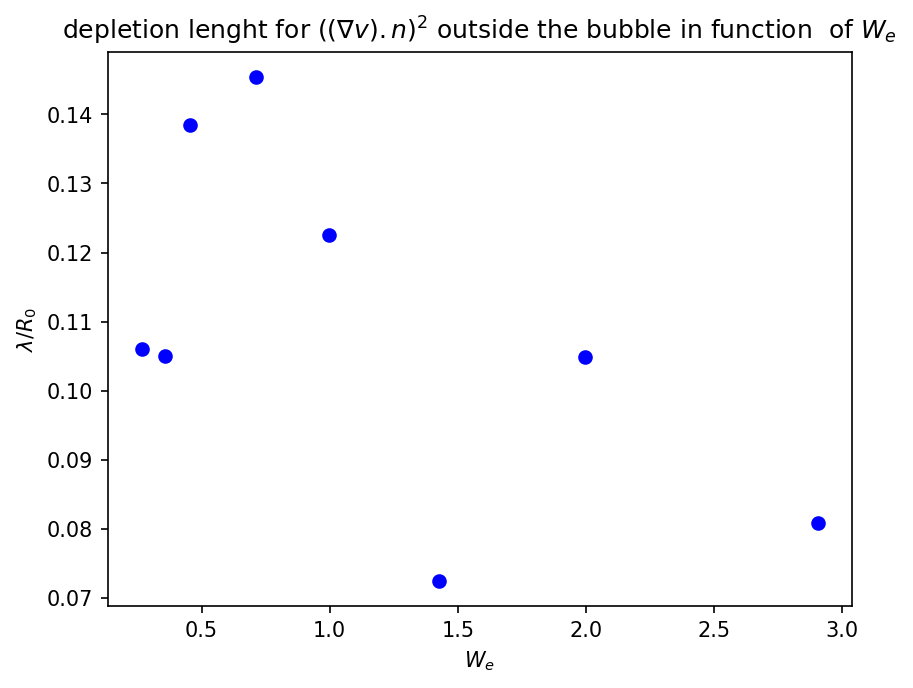

In [325]:
plt.figure(dpi=150)
i = 0
for key in gamma_sort:
#     ind = indice0[i]
#     plt.scatter(pref/key,dist2[(int(ind))]/R0,color='b')
    plt.scatter(pref/key,opti[key][0],color='b')
    i+=1
plt.xlabel('$W_e$')
plt.ylabel(r'$\lambda /R_0$')
plt.title(r'depletion lenght for (($\nabla v).n)^2$ outside the bubble in function  of $W_e$ ')
#longueur de déplétion calculée en prenant le point à partir duquel (gradv.n - moy(gradv.n) < 0)
plt.savefig( folderfig + 'depletion_gradvn_out_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/55008851.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0.5, 1.0, '(($\\nabla v).t)^2$ for different $W_e$')

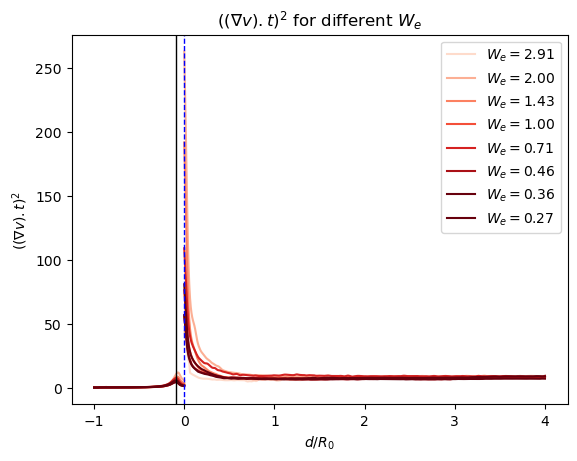

In [265]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
indice0 = np.zeros(len(gamma_sort))
for key in gamma_sort:
    if key<700:
        pass
#     moy = np.sum(vitesseext[key][4,-250:]**2+vitesseext[key][5,-250:]**2)/2/len(dist2[250:])
    line, = plt.plot(dist*(-1)/R0, (vitesseint[key][4,:]**2+vitesseint[key][5,:]**2)/2/25,color=cmap(i+1),label = f'$W_e = {pref/key:.2f}$')
    line, = plt.plot(dist2/R0, (vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2,color=cmap(i+1))
#     indice = np.argwhere(vitesseext[key][3,:]**2-moy<0)
#     indice0[i]=indice[0]
    i+=1
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).t)^2$')
# plt.xlim(-0.5,0.5)
plt.axvline(0,color='b',linestyle='--',lw=1)
plt.axvline(-3*dx/R0,color='k',lw=1) #deux cellules
plt.title(r'(($\nabla v).t)^2$ for different $W_e$')
# plt.savefig(folderfig + 'gradvt**2_We')

/tmp/ipykernel_21088/2032201289.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)
/tmp/ipykernel_21088/2640741202.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp((-1/a)*x+b)+cte
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 8. 60. 41. 31. 51. 33. 21. 42.]


Text(0.5, 1.0, '(($\\nabla v).t)^2$ for different $W_e$')

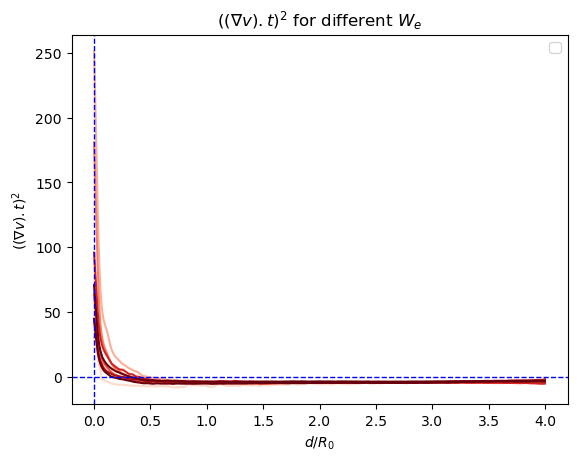

In [335]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
opti = {}
for key in gamma_sort:
    if key<700:
        pass
    moy = np.sum(vitesseext[key][4,250:]**2+vitesseext[key][5,250:]**2/2)/len(dist2[250:])

    line, = plt.plot(dist2/R0, (vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2-moy,color=cmap(i+1))
    popt, cov = curve_fit(expo_decr,dist2/R0,(vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2)
    if key not in opti:
        opti[key] = np.zeros(3)
        opti[key] = popt
    i+=1
print(indice0)
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).t)^2$')
# plt.xlim(-0.5,0.5)
plt.axvline(0,color='b',linestyle='--',lw=1)
plt.axhline(0,color='b',linestyle='--',lw=1) #deux cellules
plt.title(r'(($\nabla v).t)^2$ for different $W_e$')

/tmp/ipykernel_21088/4286385047.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


Text(0.5, 1.0, 'fit of exp function on outside $((\\nabla v).t)^2$ for $\\gamma = 2240$ ')

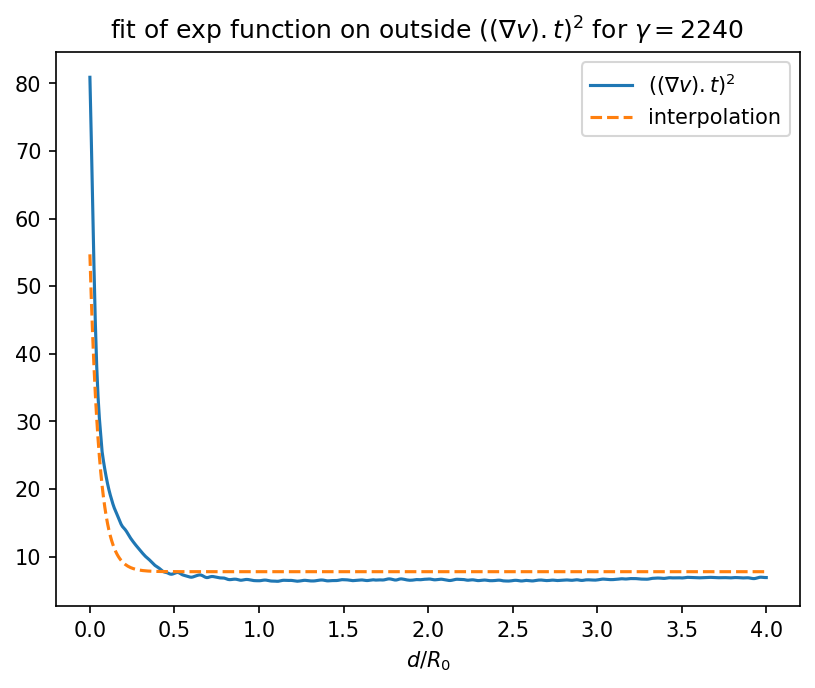

In [338]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
gam = 2240.
plt.figure(dpi=150)
plt.plot(dist2/R0,(vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2,label=r'$((\nabla v).t)^2$')
plt.plot(dist2/R0,expo_decr(dist2/R0,opti[gam][0],opti[gam][1],opti[gam][2]),linestyle = '--', label='interpolation')
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.title(r'fit of exp function on outside $((\nabla v).t)^2$ for $\gamma = 2240$ ')

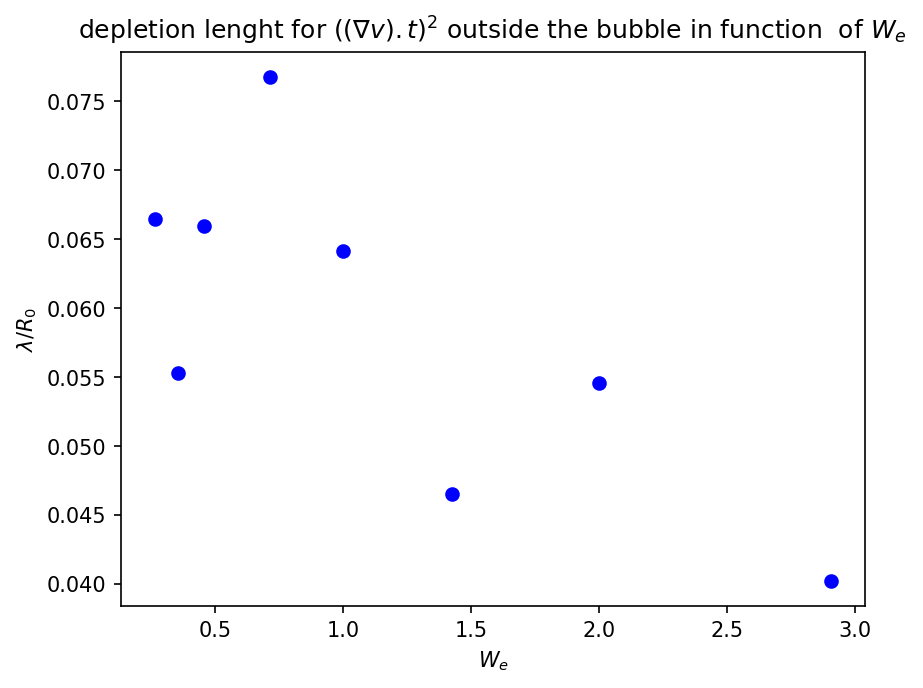

In [339]:
plt.figure(dpi=150)
i = 0
for key in gamma_sort:
    plt.scatter(pref/key,opti[key][0],color='b')
    i+=1
plt.xlabel('$W_e$')
plt.ylabel(r'$\lambda /R_0$')
plt.title(r'depletion lenght for (($\nabla v).t)^2$ outside the bubble in function  of $W_e$ ')
#longueur de déplétion calculée en prenant le point à partir duquel (gradv.n - moy(gradv.n) < 0)
plt.savefig( folderfig + 'depletion_gradvt_out_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/3290154323.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 18. 176.  65.  53. 221.  89.  48. 102.]


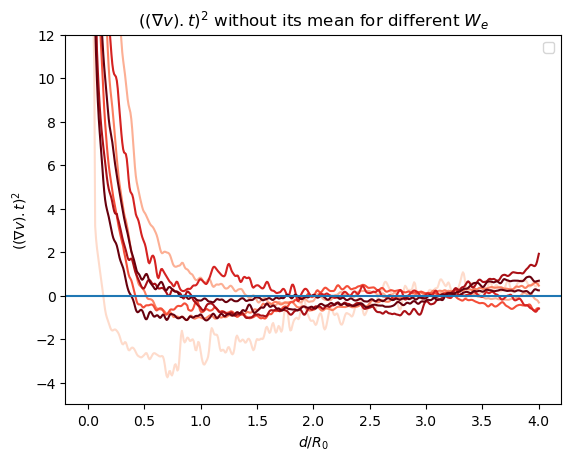

In [310]:
# cmap = plt.cm.get_cmap('Reds', 8)
# i=0
# indice0 = np.zeros(len(gamma_sort))
# for key in gamma_sort:
#     if key<700:
#         pass
#     moy = np.sum((vitesseext[key][4,-250:]**2+vitesseext[key][5,-250:]**2)/2)/len(dist2[250:])
#     line, = plt.plot(dist2/R0, (vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2-moy,color=cmap(i+1))
#     moyenne += moy
#     indice = np.argwhere((vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2-moy<0)
#     indice0[i] = indice[0]
#     i+=1
# print(indice0)
# plt.axhline(0)
# plt.legend()
# plt.ylim(-5,12)
# plt.xlabel(r'$d/R_0$')
# plt.ylabel(r'(($\nabla v).t)^2$')
# plt.title(r'(($\nabla v).t)^2$ without its mean for different $W_e$')

# plt.savefig(folderfig + 'gradvt_meanless_We.pdf', bbox_inches = 'tight')

/tmp/ipykernel_21088/1395095874.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


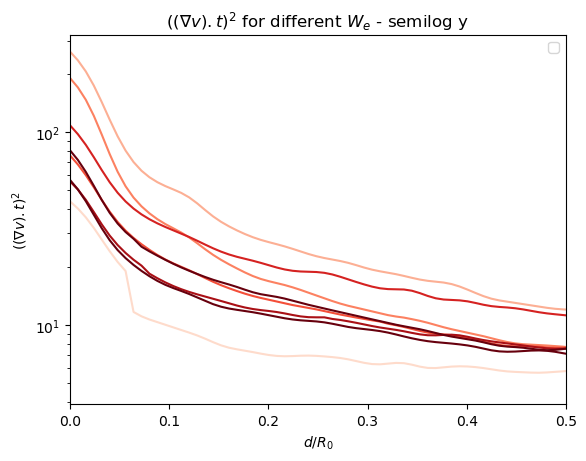

In [316]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in gamma_sort:
    if key<700:
        pass
#     moy = np.sum((vitesseext[key][4,-100:]**2+vitesseext[key][5,-100:]**2)/2)/100
    line, = plt.plot(dist2/R0, (vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2,color=cmap(i+1))
    moyenne += moy
    i+=1

plt.yscale('log')
plt.axhline(0)
plt.legend()
plt.xlim(0,0.5)

plt.xlabel(r'$d/R_0$')
plt.ylabel(r'(($\nabla v).t)^2$')
plt.title(r'(($\nabla v).t)^2$ for different $W_e$ - semilog y')
plt.savefig(folderfig + 'gradvt**2_semilog_y_We.pdf', bbox_inches = 'tight')
